# Análisis exploratorio de datos (EDA)

## Objetivo del EDA
Entender la distribución de los artículos médicos (títulos, abstracts, grupos) y detectar posibles retos (multi-label, desbalance, longitud de textos).

Cargamos y revisamos los datos

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
df = pd.read_csv('../data/challenge_data-18-ago.csv', delimiter=';')

# Vista rápida de los datos
df

,title,abstract,group
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,neurological|hepatorenal
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,neurological
...,...,...,...
3560,The effect of recombinant human insulin-like g...,We recently demonstrated that recombinant hGH ...,neurological|cardiovascular|hepatorenal
3561,EEG reveals leukemia secrets,Hypothesis: metformin improves dementia outcom...,neurological
3562,venous pathways in angina pectoris,Hypothesis: metformin improves heart disease o...,neurological|cardiovascular
3563,Thyroxine abuse: an unusual case of thyrotoxic...,Eating disorders and the associated behavioura...,neurological


## Columnas presentes en el dataset
- **title:** Título del artículo médico.
- **abstract:** Resumen científico del artículo.
- **group:** Categoría(s) médica o grupo al que pertenece el artículo.

Mostramos información básica del dataframe

In [2]:
# Revisamos los tipos de datos del DataFrame e identificamos los valores faltantes y tipos incorrectos.
df.info()
print(f'Número de filas duplicadas: {df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     3565 non-null   object
 1   abstract  3565 non-null   object
 2   group     3565 non-null   object
dtypes: object(3)
memory usage: 83.7+ KB
Número de filas duplicadas: 0


In [3]:
df.duplicated(subset=['title']).sum()  # Revisamos duplicados basándonos en la columna 'title'
# Mostramos los valores duplicados de la columna 'title'
df[df.duplicated(subset=['title'], keep=False)].sort_values(by='title')

,title,abstract,group
2246,Long term hormone therapy for perimenopausal a...,BACKGROUND: Hormone therapy (HT) is widely use...,neurological|cardiovascular|oncological
2261,Long term hormone therapy for perimenopausal a...,BACKGROUND: Hormone therapy (HT) is widely use...,neurological|cardiovascular|oncological
1433,State-of-the-art thiazide diuretics for prosta...,Research question: How does beta-blockers affe...,hepatorenal
3096,State-of-the-art thiazide diuretics for prosta...,Background: cancer affects diabetic patients w...,cardiovascular


El artículo *"Long term hormone therapy for perimenopausal and postmenopausal women."* Aparece duplicado pero al leer el abstracto pudimos identificar que uno es una versión actualizada del otro.
> This is an updated version of the original Cochrane review first published in 2005.

## Inspección a la columna "group" multilabel

### Visualización de las etiquetas

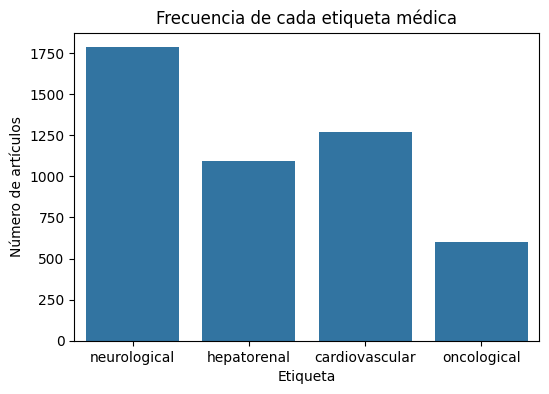

group
neurological      1785
cardiovascular    1268
hepatorenal       1091
oncological        601
Name: count, dtype: int64 



In [67]:
# Expandir grupos (multi-label)
from collections import Counter

all_labels = [g for row in df['group'].dropna() for g in row.split('|')]
label_counts = Counter(all_labels)

plt.figure(figsize=(6,4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Frecuencia de cada etiqueta médica")
plt.ylabel("Número de artículos")
plt.xlabel("Etiqueta")
plt.show()

labels = df['group'].str.split('|').explode().unique()
print(df['group'].str.split('|').explode().value_counts(), '\n')

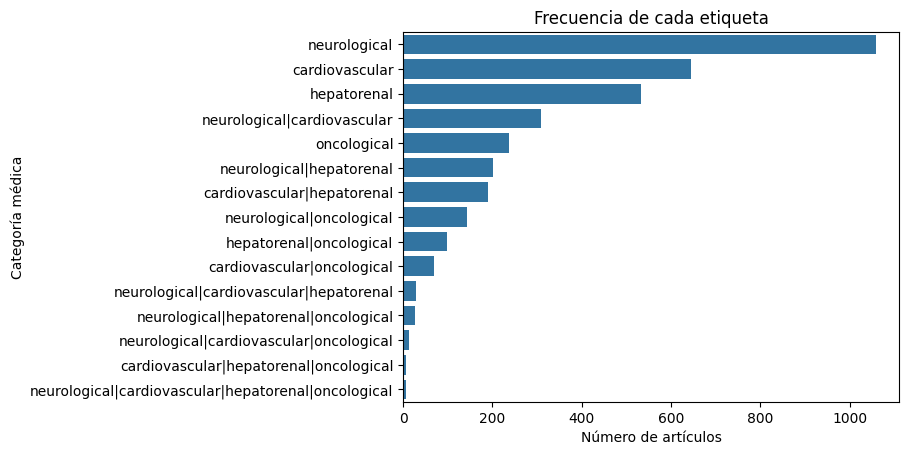

group
neurological                                           1058
cardiovascular                                          645
hepatorenal                                             533
neurological|cardiovascular                             308
oncological                                             237
neurological|hepatorenal                                202
cardiovascular|hepatorenal                              190
neurological|oncological                                143
hepatorenal|oncological                                  98
cardiovascular|oncological                               70
neurological|cardiovascular|hepatorenal                  28
neurological|hepatorenal|oncological                     26
neurological|cardiovascular|oncological                  13
cardiovascular|hepatorenal|oncological                    7
neurological|cardiovascular|hepatorenal|oncological       7
Name: count, dtype: int64


In [ ]:
# Revisamos los valores únicos en la columna 'group'
label_counts = df["group"].str.get_dummies(sep=",").sum().sort_values(ascending=False)
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.xlabel("Número de artículos")
plt.ylabel("Categoría médica")
plt.title("Frecuencia de cada etiqueta")
plt.show()

print(df['group'].value_counts())

### Número de etiquetas por artículo

C:\Users\jucep\AppData\Local\Temp\ipykernel_16744\3713430204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='num_labels', palette='Set2')


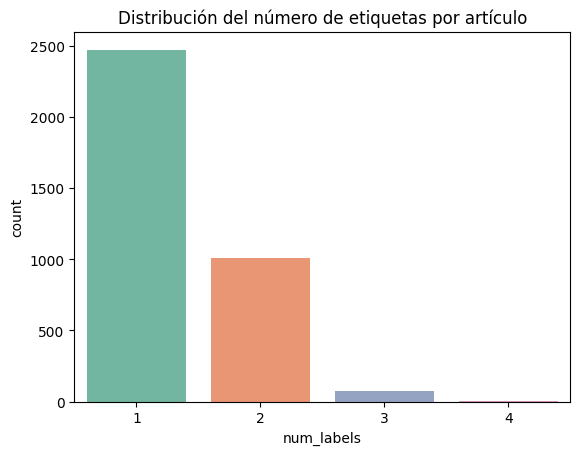

num_labels
1    2473
2    1011
3      74
4       7
Name: count, dtype: int64


In [68]:
df['num_labels'] = df['group'].apply(lambda x: len(x.split('|')))
sns.countplot(data=df, x='num_labels', palette='Set2')
plt.title("Distribución del número de etiquetas por artículo")
plt.show()

print(df['num_labels'].value_counts())

### Co-ocurrencia de etiquetas 

Mapa de calor con matriz de co-ocurrencia entre pares de etiquetas

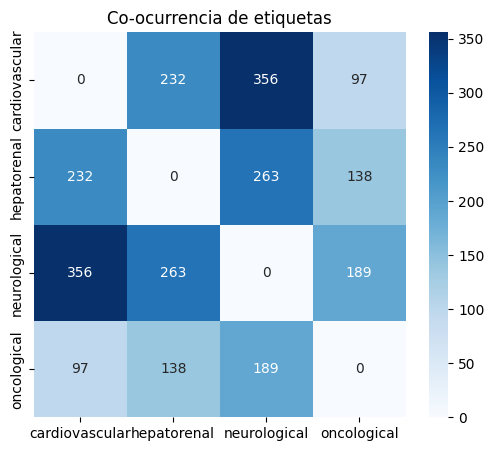

In [ ]:
unique_labels = sorted(set(all_labels))
co_matrix = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

for groups in df['group']:
    labels = groups.split('|')
    for i in labels:
        for j in labels:
            if i != j:
                co_matrix.loc[i, j] += 1

plt.figure(figsize=(6,5))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Co-ocurrencia de etiquetas")
plt.show()

## Natural Language Processing (NLP)

### Longitud de los textos

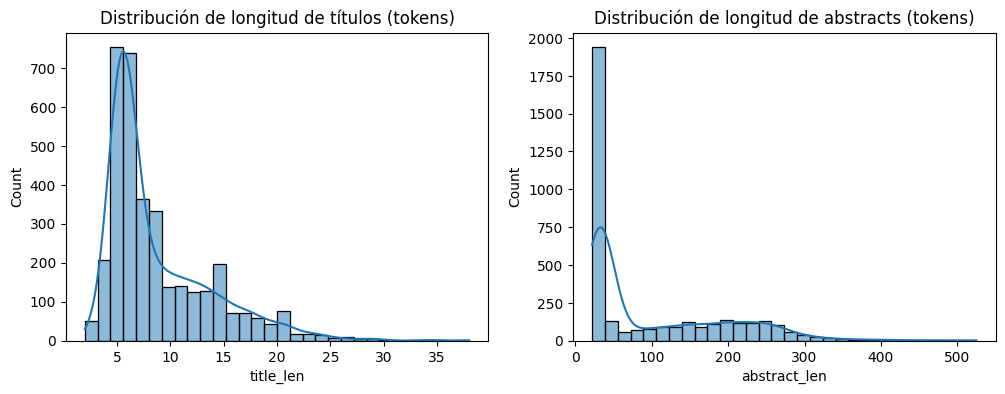

In [75]:
df['title_len'] = df['title'].apply(lambda x: len(str(x).split()))
df['abstract_len'] = df['abstract'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['title_len'], bins=30, ax=axes[0], kde=True)
axes[0].set_title("Distribución de longitud de títulos (tokens)")

sns.histplot(df['abstract_len'], bins=30, ax=axes[1], kde=True)
axes[1].set_title("Distribución de longitud de abstracts (tokens)")

plt.show()


### Palabras más frecuentes

Limpiamos el texto de las stopwords para enfocarnos en palabras más significativas y lo normalizamos.

In [90]:
# Librerías para procesamiento de texto
# from collections import Counter # Ya importado arriba
import re
import nltk
from wordcloud import WordCloud

stopwords = set(nltk.corpus.stopwords.words("english"))

def clean_and_tokenize(text):
    tokens = re.findall(r"\b\w+\b", str(text).lower())
    return [t for t in tokens if t not in stopwords]

all_tokens = []
for text in df['abstract'].dropna():
    all_tokens.extend(clean_and_tokenize(text))

freqs = Counter(all_tokens).most_common(20)
pd.DataFrame(freqs, columns=["word","count"]).head(10)


,word,count
0,patients,4291
1,results,2626
2,methods,1927
3,study,1877
4,conclusion,1562
5,cancer,1520
6,1,1374
7,disease,1289
8,0,1247
9,treatment,1120


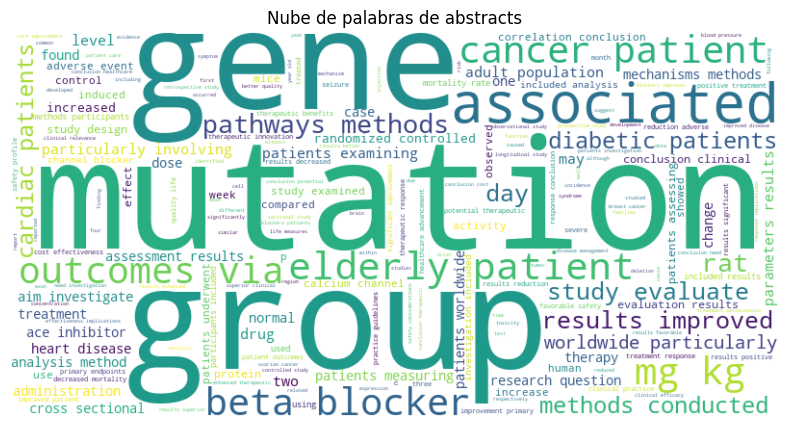

In [81]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_tokens))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de abstracts")
plt.show()


### NLP - Top terms por categoría TF-IDF 

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X = tfidf.fit_transform(df['abstract'])

def top_terms_for_class(label, n=10):
    idx = df['group'].str.contains(label).values  # <-- .values para obtener un array booleano
    class_mean = X[idx].mean(axis=0).A1
    terms = np.array(tfidf.get_feature_names_out())
    top_idx = class_mean.argsort()[-n:][::-1]
    return list(zip(terms[top_idx], class_mean[top_idx]))

for label in unique_labels:
    print(f"\nTop términos para {label}:")
    print(top_terms_for_class(label, 10))
    


Top términos para cardiovascular:
[('patients', np.float64(0.059157873036861666)), ('results', np.float64(0.0512517788911076)), ('methods', np.float64(0.04970945673029342)), ('conclusion', np.float64(0.04853058739808192)), ('heart', np.float64(0.04532040354173932)), ('study', np.float64(0.042015937320463374)), ('investigation', np.float64(0.037552754318903286)), ('disease', np.float64(0.03591517673212306)), ('implications', np.float64(0.034943586186759336)), ('cancer', np.float64(0.0329753544416205))]

Top términos para hepatorenal:
[('patients', np.float64(0.0554546126582366)), ('methods', np.float64(0.04515532315928674)), ('results', np.float64(0.044603794032472)), ('conclusion', np.float64(0.04297910992399811)), ('renal', np.float64(0.038768537222767435)), ('study', np.float64(0.03549803404822544)), ('cancer', np.float64(0.030660583533485088)), ('disease', np.float64(0.03046229742420567)), ('investigation', np.float64(0.029858959299192935)), ('implications', np.float64(0.0298285303

Graficamos para mejor vista de los datos

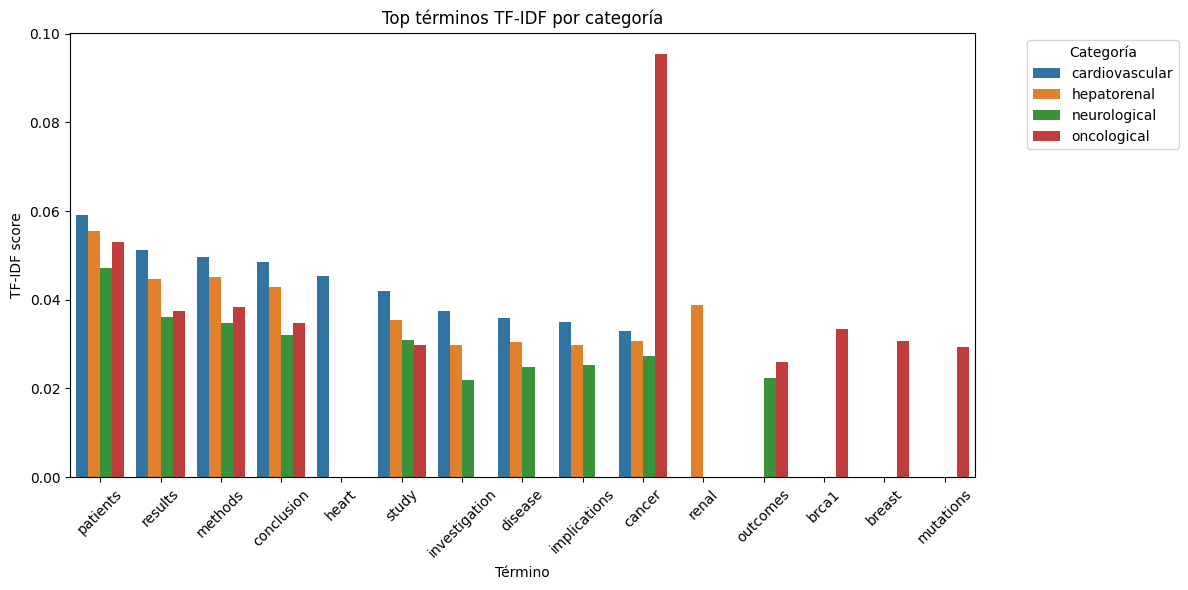

In [96]:
# Guardamos los resultados en un DataFrame
top_terms = []
for label in unique_labels:
    terms_scores = top_terms_for_class(label, 10)
    for term, score in terms_scores:
        top_terms.append({'label': label, 'term': term, 'score': score})

df_top_terms = pd.DataFrame(top_terms)

# Graficamos los términos más relevantes por categoría
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_top_terms,
    x='term', y='score', hue='label'
)
plt.title('Top términos TF-IDF por categoría')
plt.ylabel('TF-IDF score')
plt.xlabel('Término')
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# One Hot Encoding de la columna 'group'
df_encoded = pd.get_dummies(df, columns=['group'], prefix='', prefix_sep='')    
# Mostramos información básica del dataframe
df_encoded

,title,abstract,cardiovascular,cardiovascular|hepatorenal,cardiovascular|hepatorenal|oncological,cardiovascular|oncological,hepatorenal,hepatorenal|oncological,neurological,neurological|cardiovascular,neurological|cardiovascular|hepatorenal,neurological|cardiovascular|hepatorenal|oncological,neurological|cardiovascular|oncological,neurological|hepatorenal,neurological|hepatorenal|oncological,neurological|oncological,oncological
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560,The effect of recombinant human insulin-like g...,We recently demonstrated that recombinant hGH ...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3561,EEG reveals leukemia secrets,Hypothesis: metformin improves dementia outcom...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3562,venous pathways in angina pectoris,Hypothesis: metformin improves heart disease o...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3563,Thyroxine abuse: an unusual case of thyrotoxic...,Eating disorders and the associated behavioura...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
